# Importer les packages

In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import shap
import random
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, KFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score

# Charger les données

Les données sont chargées, et les colonnes comportants des nombres flottants sont réadapter pour pandas.

In [4]:
data = pd.read_csv('labeled_full_metrics_release-2.0.0.csv')
liste = ['CCViolDensityLine','CCViolDensityCode','RatioCommentToCode']
for elm in liste:
    data[elm] = data[elm].str.replace(',', '.').astype(float)
data.head(5)

,Version,CommitId,Name,AvgCountLine,AvgCountLineBlank,AvgCountLineCode,AvgCountLineComment,AvgCyclomatic,CountClassBase,CountClassCoupled,...,CountDeclMethodConst,CountDeclMethodFriend,CountLineInactive,CountLinePreprocessor,CountStmtEmpty,CountCCViol,CountCCViolType,CCViolDensityLine,CCViolDensityCode,BugStatus
0,release-2.0.0,f90366404453ad9a42ed389f89dc7a23ccaa863c,AMReporter.java,11,0,11,0,2,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0,0,0.0,0.0,0
1,release-2.0.0,f90366404453ad9a42ed389f89dc7a23ccaa863c,ASTBuilder.java,13,0,12,0,4,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0,0,0.0,0.0,1
2,release-2.0.0,f90366404453ad9a42ed389f89dc7a23ccaa863c,ASTConverter.java,17,1,14,2,3,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0,0,0.0,0.0,1
3,release-2.0.0,f90366404453ad9a42ed389f89dc7a23ccaa863c,ASTErrorNode.java,2,0,2,0,1,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0,0,0.0,0.0,0
4,release-2.0.0,f90366404453ad9a42ed389f89dc7a23ccaa863c,ASTNode.java,10,1,8,1,2,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0,0,0.0,0.0,1


# Préparation des variables
La version du commit, son id et le nom du fichier n'est pas pris en compte dans l'entraînement du modèle. Toutes les colonnes comportant un `NaN` sont inutilisables et supprimées.

In [5]:
X = data.drop(columns=['BugStatus','Version','CommitId', 'Name']) # variables indépendantes
X = X.dropna(axis=1)
y = data['BugStatus'] # présence d'un bug

# Données d'entraînements et de test
L'ensemble des données est divisé en 5 parties égales sur lesquelles le modèle s'entraîne. La validation est réalisée [de manière croisée](https://medium.com/@tubelwj/five-methods-for-data-splitting-in-machine-learning-27baa50908ed) pour déterminer plus précisément l'efficacité de notre modèle.

In [20]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)
for train_index, val_index in kf.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[val_index]
    y_train, y_test = y.iloc[train_index], y.iloc[val_index]

# Entrainement du modèle

Comparaison entre la régression logistique et la forêt aléatoire.

In [21]:
model1 = LogisticRegression()
model2 = RandomForestClassifier(n_estimators=100, random_state=42)

model1.fit(X_train, y_train)
model2.fit(X_train, y_train)

C:\Users\yanth\VSCodeProjects\MGL869-Lab-Hive\venv\lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


BugStatus
0    3088
1     557
Name: count, dtype: int64


# Prédictions

In [31]:
y_pred1 = model1.predict(X_test)
print("Prédictions logistic regression :", y_pred1[:5],"..")
y_pred2 = model2.predict(X_test)
print("Prédictions random forest :", y_pred2[:5],"..")
print("Valeurs réelles :", y_test.values[:5],"..")

Prédictions logistic regression : [0 0 0 0 0] ..
Prédictions random forest : [0 0 0 1 0] ..
Valeurs réelles : [0 1 0 0 0] ..


# Evaluer la performance du modèle

Les 2 modèles sont comparés par leur AUC, leur précision et leur taux de rappel. La **forêt aléatoire** est un meilleur modèle pour la détermination de la présence de bugs dans un commit.

In [35]:
auc1 = roc_auc_score(y_test, y_pred1)
auc2 = roc_auc_score(y_test, y_pred2)

print(classification_report(y_test, y_pred1))
print(f"AUC Logistic Regression: {auc1}")
print("-"*60)

print(classification_report(y_test, y_pred2))
print(f"AUC Random Forest: {auc2}")

Accuracy logistic regression: 0.849615806805708
              precision    recall  f1-score   support

           0       0.87      0.97      0.92       774
           1       0.50      0.18      0.27       137

    accuracy                           0.85       911
   macro avg       0.68      0.58      0.59       911
weighted avg       0.81      0.85      0.82       911

AUC Logistic Regression: 0.5750910051113752
------------------------------------------------------------
Accuracy random forest: 0.8682766190998902
              precision    recall  f1-score   support

           0       0.88      0.97      0.93       774
           1       0.64      0.28      0.39       137

    accuracy                           0.87       911
   macro avg       0.76      0.63      0.66       911
weighted avg       0.85      0.87      0.85       911

AUC Random Forest: 0.6281238801184481


# Importance des variables

## Valeur SHAP

Pour déterminer si une variable est plus importante qu'une autre dans la détermination de la présence d'un bug, on utilise [sa valeur **SHAP** (**SH**apley **A**dditive ex**P**lanations)](https://towardsdatascience.com/using-shap-values-to-explain-how-your-machine-learning-model-works-732b3f40e137). Elle mesure la contribution d'une variable dans la prédiction du modèle.

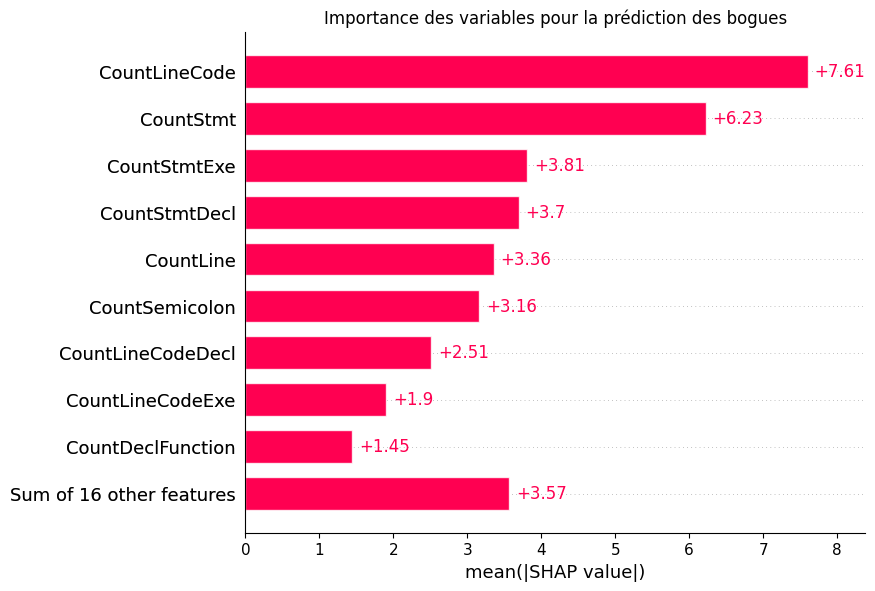

In [42]:
explainer = shap.Explainer(model1, X_train)
shap_values = explainer(X_test)

shap.plots.bar(shap_values, show=False)
plt.title("Importance des variables pour la prédiction des bogues")
plt.savefig('mon_graphique.png')
plt.show()

## Sélection des meilleures valeurs

On utilise uniquement les 5 meilleures variables pour l'entraînement et la prédication des variables.

In [51]:
shap_df = pd.DataFrame(shap_values.values, columns=X_test.columns)
mean_shap = shap_df.abs().mean()
top_5_variables = mean_shap.nlargest(5)
print("Les 5 variables les plus importantes :")
print(top_5_variables)
top_5_variables = top_5_variables.index.tolist()

Les 5 variables les plus importantes :
CountLineCode    7.605159
CountStmt        6.225731
CountStmtExe     3.810040
CountStmtDecl    3.699176
CountLine        3.362503
dtype: float64


In [53]:
X = data[top_5_variables] # variables indépendantes
y = data['BugStatus'] # présence d'un bug
model2.fit(X_train, y_train) # modèle forêt aléatoire
y_pred2 = model2.predict(X_test)
print(classification_report(y_test, y_pred2))
print(f"AUC Random Forest: {auc2}")

              precision    recall  f1-score   support

           0       0.88      0.97      0.93       774
           1       0.64      0.28      0.39       137

    accuracy                           0.87       911
   macro avg       0.76      0.63      0.66       911
weighted avg       0.85      0.87      0.85       911

AUC Random Forest: 0.6281238801184481
